In [51]:
# 說明：設置環境、import 套件
import pandas as pd
import numpy as np
import pprint 
import matplotlib.pyplot as plt
from matplotlib import pylab
%pylab inline
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (20, 8)

Populating the interactive namespace from numpy and matplotlib


In [35]:
# Global variables
CostRate = 3

## Part 0: Data Pre-processing
- 先做一些設置，以便後續整理
    - 將欄位index設成英文
    - 將資料改為英文（避開畫圖中文問題）

### 欄位
- 原index: ['﻿時  間', '區 域', '館 舍 別', '迴 路 別', '用電別', '用電量(單位:度)']
- 新index:
- 我用Number(Excel)的尋找取代功能，把資料轉成英文，以下括弧表示原始資料的命名
    - 區域：southArea(南區), northArea(北區)
    - 迴 路 別: mainLoop（主迴路）, familyMart（1F便利超商）, club（社團）, socialHall（閱覽交誼廳）, studentHall（學生交誼廳）, streetLight(環校路燈),
    - 館舍： dorm_13（學生十三舍）,(7,8,9,10,11,12 以此類推), dorm_graduate_2（研二）, dorm_87（學生七舍＿八舍）, dorm_13_graduate_1(11與研一), dorm_chu（竹軒）
    - 用電別：rent（外租）, dorm（宿舍）, admin(行政)
    


In [36]:
# 讀檔案
# 用.head()看長什麼樣子
df = pd.read_csv('data/data0226_0901_1110_hr_dorm.csv')
df.columns
df.head()

,DateTime,Area,Building,Loop,Type,Usage
0,2017/09/01 00:00,southArea,dorm_13,familyMart,rent,0.0
1,2017/09/01 01:00,southArea,dorm_13,familyMart,rent,0.0
2,2017/09/01 02:00,southArea,dorm_13,familyMart,rent,0.0
3,2017/09/01 03:00,southArea,dorm_13,familyMart,rent,0.0
4,2017/09/01 04:00,southArea,dorm_13,familyMart,rent,0.0


### 將DateTime的資訊抽出，新增三個欄位
- def generate_date_time_columns(df)
    - 放進一個含有 DateTime 欄位的 df, 並寫且回傳新增 Date, Time, Weekday的欄位
- Date, Time: 為了之後更方便用日期、時間去存取，分群比較。
- Weekday: 為了去了解週一到週日的用電變化

In [37]:
def generate_date_time_columns(df):
    if('DateTime' in df.columns):
            df['Date'] = df.DateTime.str[:10]
            df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
            df['Weekday'] = df['Date'].dt.dayofweek + 1
            df['Time'] = df.DateTime.str[11:]
            df['Week'] = df['Date'].dt.week
            print('Columns #Date, #Time, #Weekday, #Week has been generated from DateTime and added to DataFrame')
    else:
        print('DataTime not in column. Please rename columns name.')
    return df

In [38]:
df = generate_date_time_columns(df)

Columns #Date, #Time, #Weekday, #Week has been generated from DateTime and added to DataFrame


In [39]:
# cost_rate：一度電大概多少錢
def generate_cost_estimate(df, cost_rate):
    df['Cost'] = df.Usage * cost_rate
    print(df.columns)
    return df

In [40]:
df = generate_cost_estimate(df, CostRate)

Index(['DateTime', 'Area', 'Building', 'Loop', 'Type', 'Usage', 'Date',
       'Weekday', 'Time', 'Week', 'Cost'],
      dtype='object')


In [41]:
#依類別分出 sub-dataframe
df_dorm = df[df.Type == 'dorm']
df_rent = df[df.Type == 'rent']
df_admin = df[df.Type == 'admin']
df_low_usage = df[df.Usage < 10]
#以下專注在 df_dorm的分析

In [42]:
# 找離群值：找出最大的五個值，用肉眼可以看出離群值
df_dorm.sort_values('Usage')[-5:]

,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Week,Cost
19247,2017/09/21 23:00,southArea,dorm_87,mainLoop,dorm,346.00,2017-09-21,4,23:00,38,1038.00
19367,2017/09/26 23:00,southArea,dorm_87,mainLoop,dorm,348.00,2017-09-26,2,23:00,39,1044.00
19343,2017/09/25 23:00,southArea,dorm_87,mainLoop,dorm,350.00,2017-09-25,1,23:00,39,1050.00
1955,2017/09/11 11:00,southArea,dorm_13,club,dorm,1039.70,2017-09-11,1,11:00,37,3119.10
6277,2017/10/19 13:00,northArea,dorm_10,studentHall,dorm,55471.62,2017-10-19,4,13:00,42,166414.86


In [43]:
# 手動改離群值，如果離群值太多得用更完整的方式
df.loc[6277,'Usage']  = 0.87 
df.loc[6277,'Cost']  = df.loc[6277,'Usage'] * CostRate

df.iloc[6277]
# 看這印出來多整齊 :D

DateTime       2017/10/19 13:00
Area                  northArea
Building                dorm_10
Loop                studentHall
Type                       dorm
Usage                      0.87
Date        2017-10-19 00:00:00
Weekday                       4
Time                      13:00
Week                         42
Cost                       2.61
Name: 6277, dtype: object

In [44]:
# 這天的離群值，猜測來自之前欄位的位移
# 驗證：看之前欄位的值，有2145筆是零
print(df.iloc[4207:6277].Usage.value_counts())

0.00    2045
0.25       6
0.26       4
0.24       3
0.19       3
0.22       2
0.21       2
0.20       2
0.01       1
5.41       1
3.24       1
Name: Usage, dtype: int64


## Part 1: Understand our data

In [45]:
# 用自訂函式去理解DF中每個欄位有哪幾種類別的值
def understand(df):
    for col_name in df.columns:
        print ('>>>{} has {} unique values:'.format(col_name, len(df[col_name].unique())))
        if(len(df[col_name].unique())<50):
            pprint.pprint(df[col_name].unique())
#         print(df[col_name].value_counts)

understand(df_dorm)

>>>DateTime has 1704 unique values:
>>>Area has 2 unique values:
array(['southArea', 'northArea'], dtype=object)
>>>Building has 12 unique values:
array(['dorm_13', 'dorm_10', 'dorm_chu', 'dorm_9', 'dorm_11_graduate_1',
       'dorm_11', 'dorm_graduate_1', 'dorm_87', 'dorm_7', 'dorm_8',
       'dorm_12', 'dorm_graduate_2'], dtype=object)
>>>Loop has 4 unique values:
array(['club', 'socialHall', 'studentHall', 'mainLoop'], dtype=object)
>>>Type has 1 unique values:
array(['dorm'], dtype=object)
>>>Usage has 2623 unique values:
>>>Date has 71 unique values:
>>>Weekday has 7 unique values:
array([5, 6, 7, 1, 2, 3, 4])
>>>Time has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)
>>>Week has 11 unique values:
array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])
>>>Cos

# Part 2 Dorm 12 分析
想想看一棟大樓的資料趨勢，可以做哪些分析？分開嘗試之後，下一步是寫成一個 function，只要餵進df，就把這些分析都跑一次

In [46]:
df_dorm_12 = df[df.Building == 'dorm_12']

In [47]:
understand(df_dorm_12)

>>>DateTime has 1704 unique values:
>>>Area has 1 unique values:
array(['southArea'], dtype=object)
>>>Building has 1 unique values:
array(['dorm_12'], dtype=object)
>>>Loop has 1 unique values:
array(['mainLoop'], dtype=object)
>>>Type has 1 unique values:
array(['dorm'], dtype=object)
>>>Usage has 336 unique values:
>>>Date has 71 unique values:
>>>Weekday has 7 unique values:
array([5, 6, 7, 1, 2, 3, 4])
>>>Time has 24 unique values:
array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)
>>>Week has 11 unique values:
array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])
>>>Cost has 336 unique values:


In [48]:
df_dorm_12.describe()

,Usage,Weekday,Week,Cost
count,1704.000000,1704.000000,1704.000000,1704.000000
mean,96.243545,4.014085,40.140845,288.730634
std,38.961526,1.989943,2.952571,116.884579
min,19.000000,1.000000,35.000000,57.000000
25%,69.000000,2.000000,38.000000,207.000000
50%,90.000000,4.000000,40.000000,270.000000
75%,120.500000,6.000000,43.000000,361.500000
max,238.500000,7.000000,45.000000,715.500000


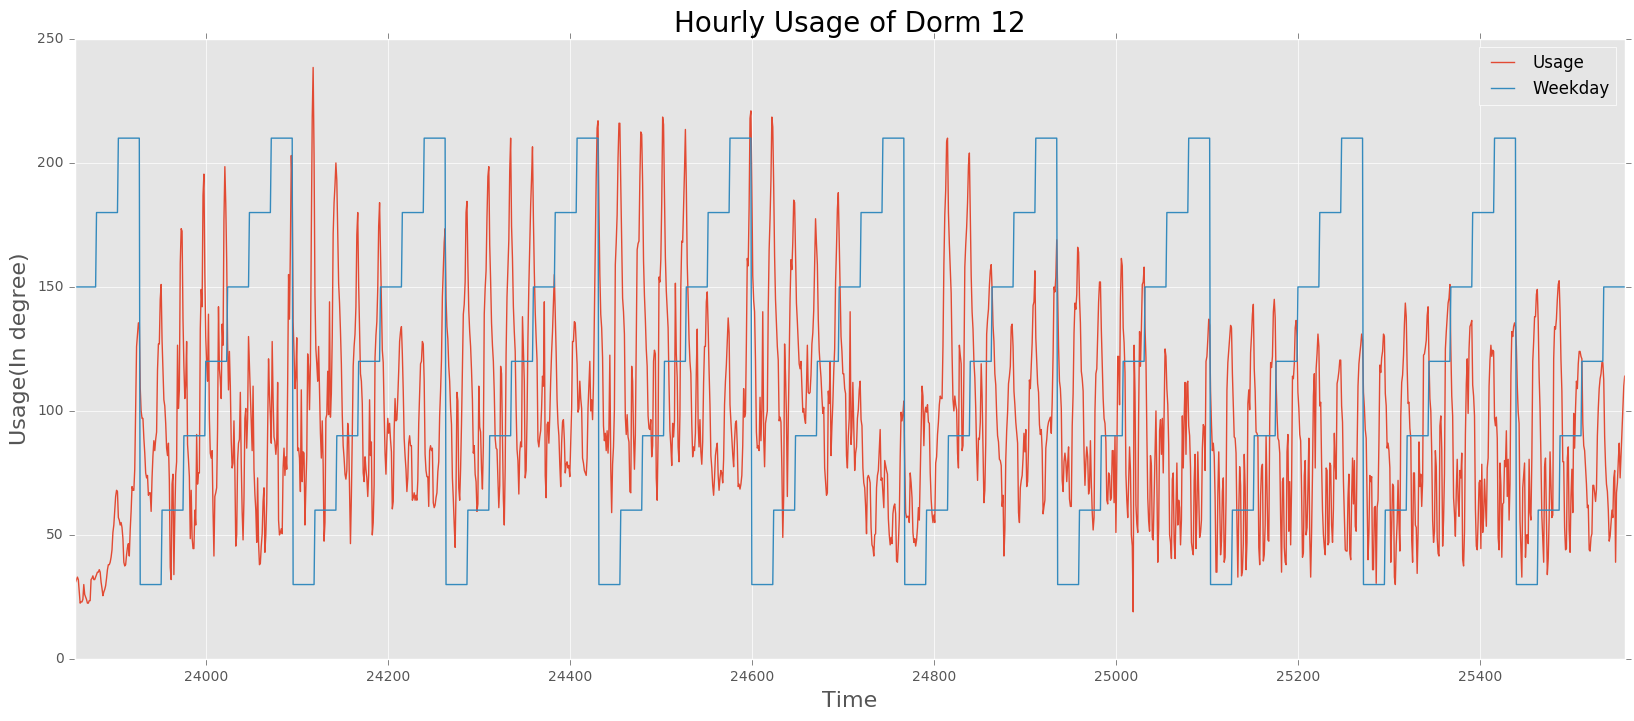

In [52]:
# 71 天每小時的用電資料 (1704個點)
df_dorm_12.Usage.plot(legend = True)
(df_dorm_12.Weekday * 30).plot(legend = True)
# plt.xlabel('index')
plt.title('Hourly Usage of Dorm 12', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Time',fontsize = 16)

### 觀察
- 週末的時候，通常用電比較低
- 圖片中間有個低潮，應該是國慶連假

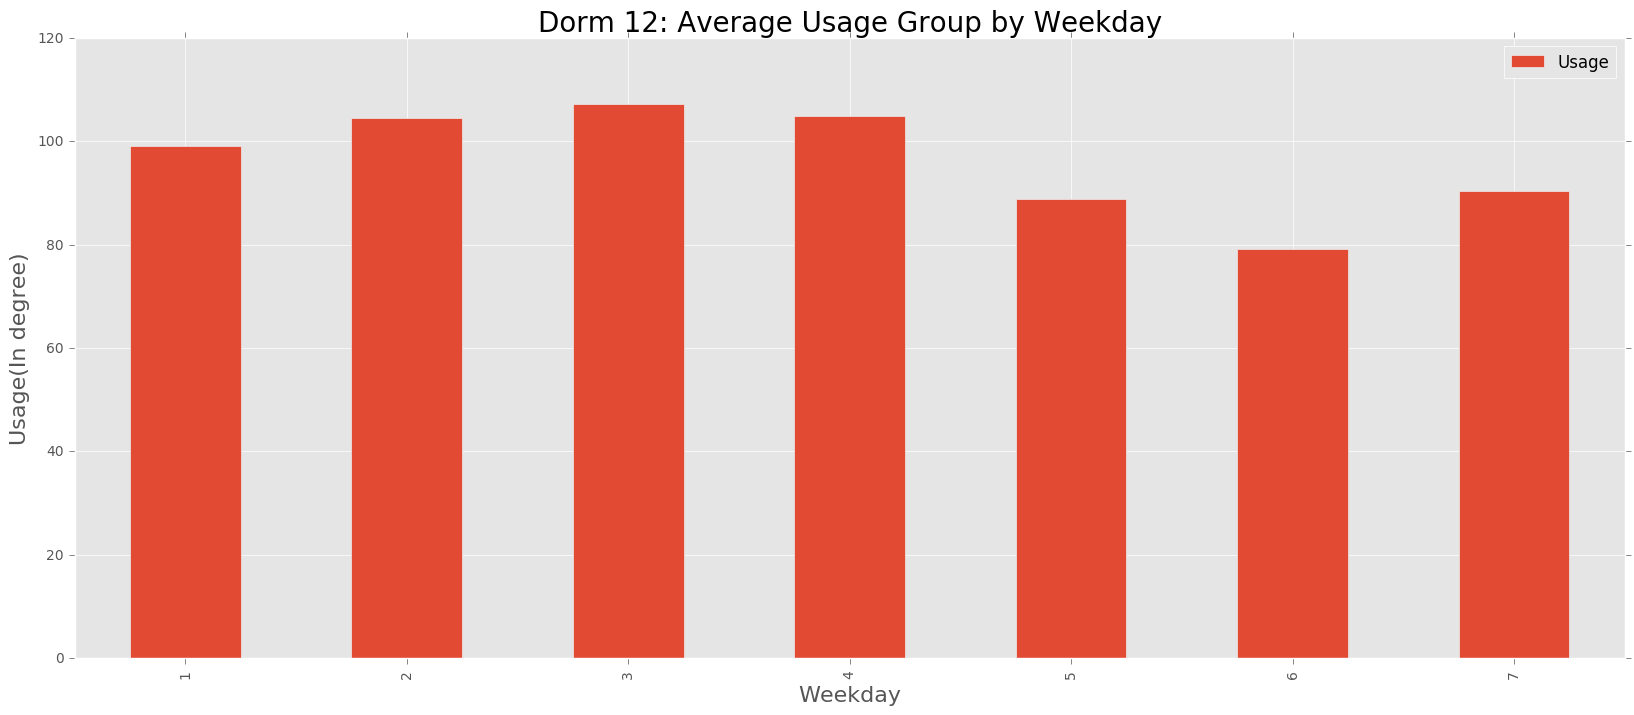

In [53]:
df_dorm_12_byWeekday = df_dorm_12.groupby('Weekday').mean()
df_dorm_12_byWeekday.Usage.plot.bar(legend = True)

plt.title('Dorm 12: Average Usage Group by Weekday', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Weekday',fontsize = 16)

### 觀察
- 週六大家回家，平均用電最低
- 週日回宿舍，用電比週六週五高

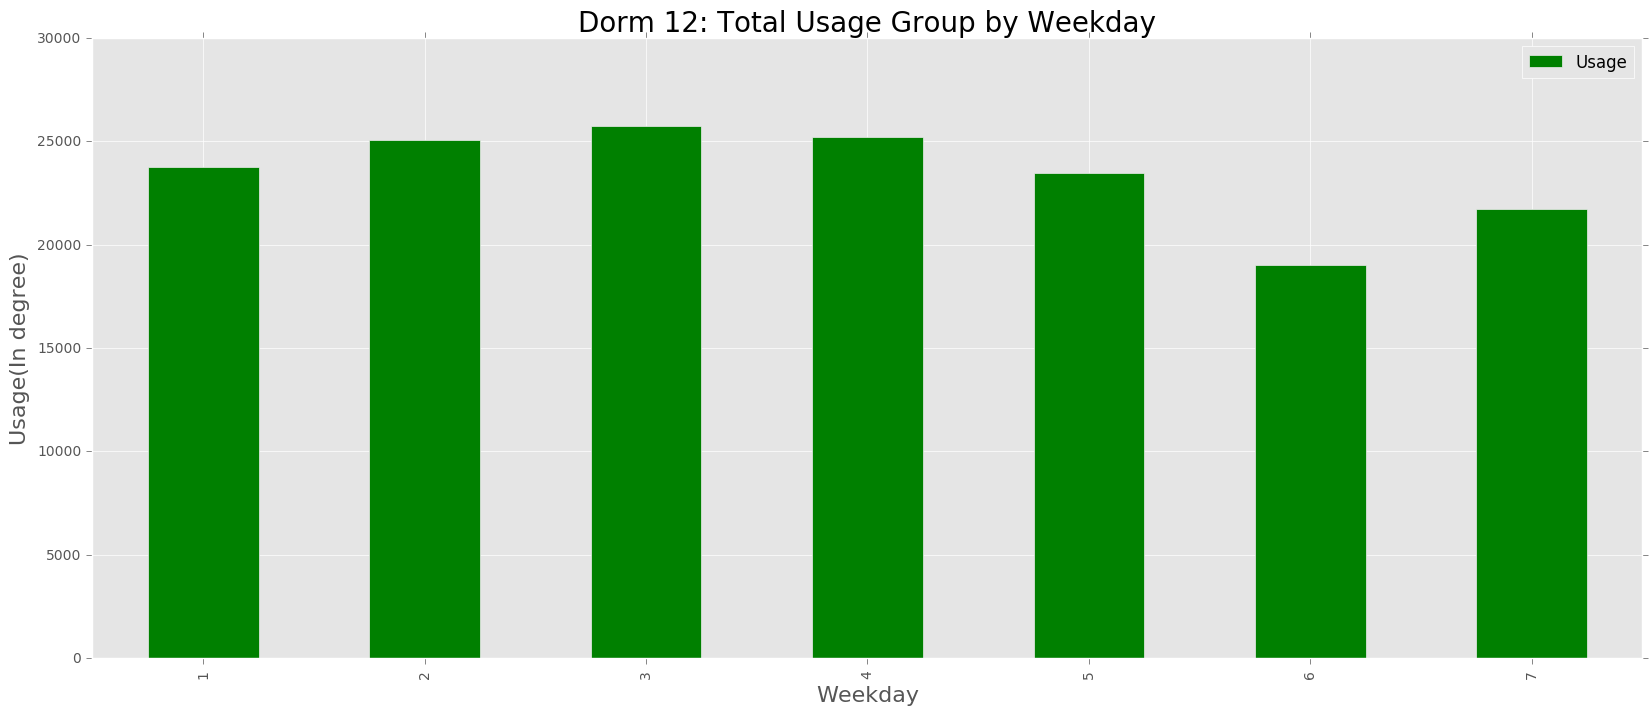

In [54]:
df_dorm_12_byWeekday = df_dorm_12.groupby('Weekday').sum()
df_dorm_12_byWeekday.Usage.plot.bar(legend = True, color = 'green')

plt.title('Dorm 12: Total Usage Group by Weekday', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Weekday',fontsize = 16)

### 觀察
- 週五的平均值略小於週日，但總和超過，原因發現是資料裡面有比較多筆週五資料

In [55]:
df_dorm_12.Weekday.value_counts()

5    264
7    240
6    240
4    240
3    240
2    240
1    240
Name: Weekday, dtype: int64

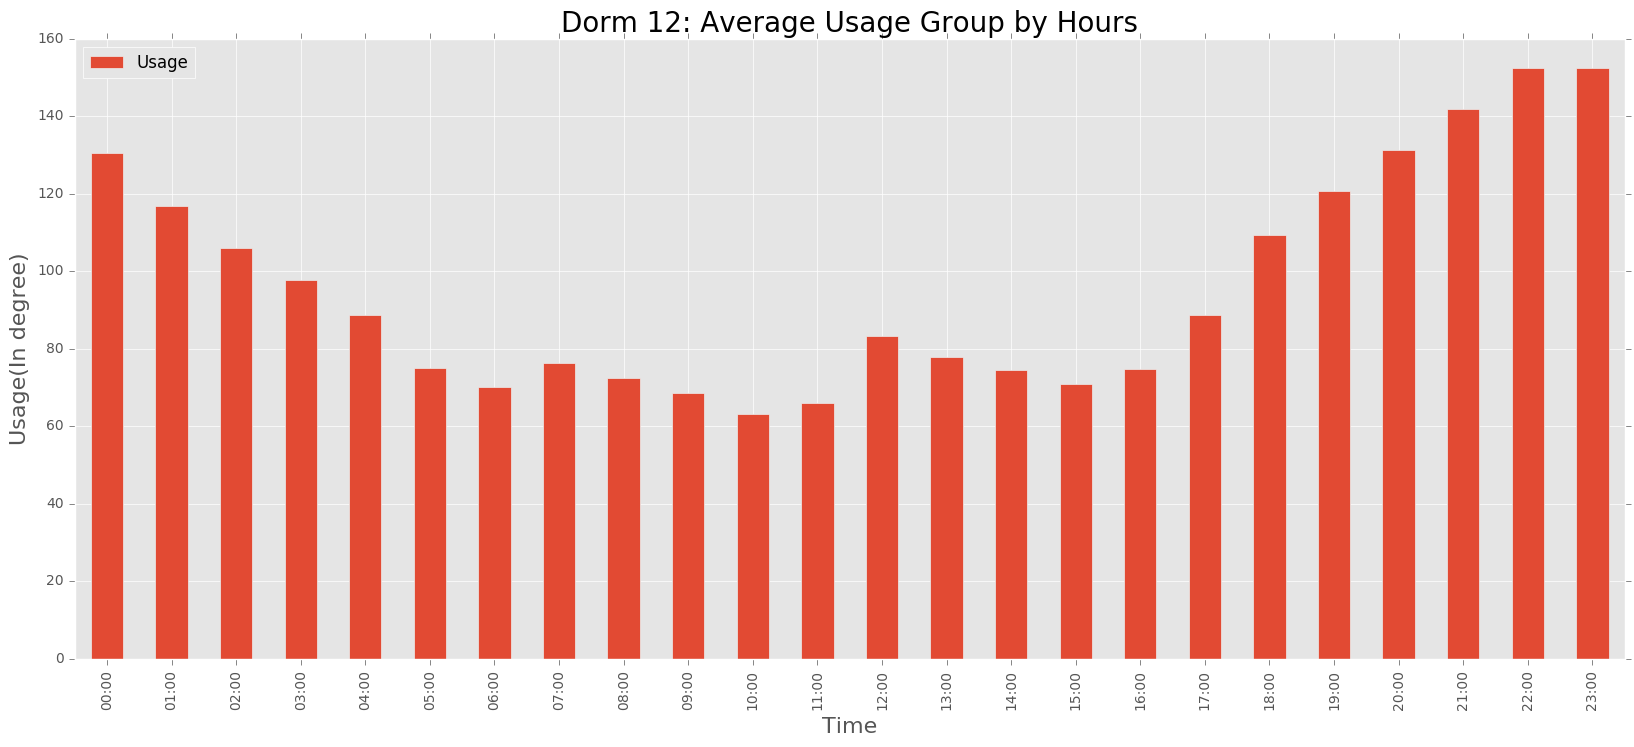

In [56]:
df_dorm_12.groupby('Time').Usage.mean().plot.bar(legend = True)
plt.title('Dorm 12: Average Usage Group by Hours', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Time',fontsize = 16)

### 觀察
- 這張是我覺得最有趣的，想法：可以拿去跟男生十舍比，看十二舍的人是不是比較早睡（省電）
- 最高用電落在晚上十一點到十二點。十二點會關燈。
- 關燈之後的下跌應該就是人為用電的減少（去睡覺了），人為用電除了桌電、吹風機以外，不知道洗澡熱水器有沒有被算在內？
- 早上七點起床有個Peak，可能是洗澡或開燈
- 中午十二點也有Peak，可能是回宿舍吃中飯
- 晚上六點開燈，所以用電升幅大

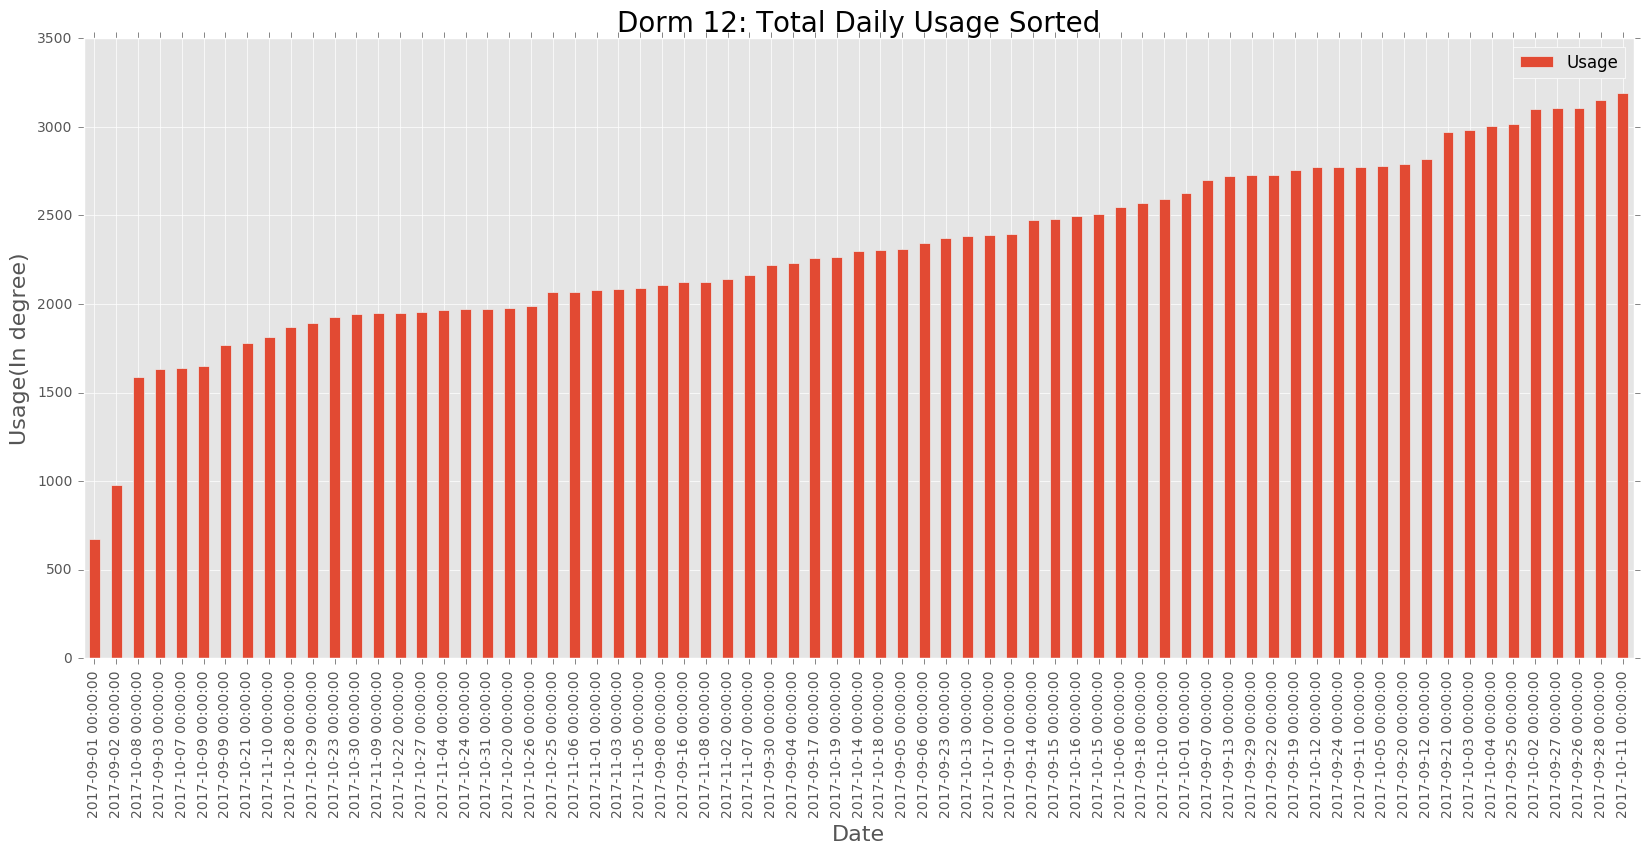

In [57]:
df_dorm_12_dailysum_sorted = df_dorm_12.groupby('Date').sum().sort_values('Usage')
df_dorm_12_dailysum_sorted.Weekday = df_dorm_12_dailysum_sorted.Weekday/24
df_dorm_12_dailysum_sorted.Usage.plot.bar(legend = True)
plt.title('Dorm 12: Total Daily Usage Sorted', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Date',fontsize = 16)

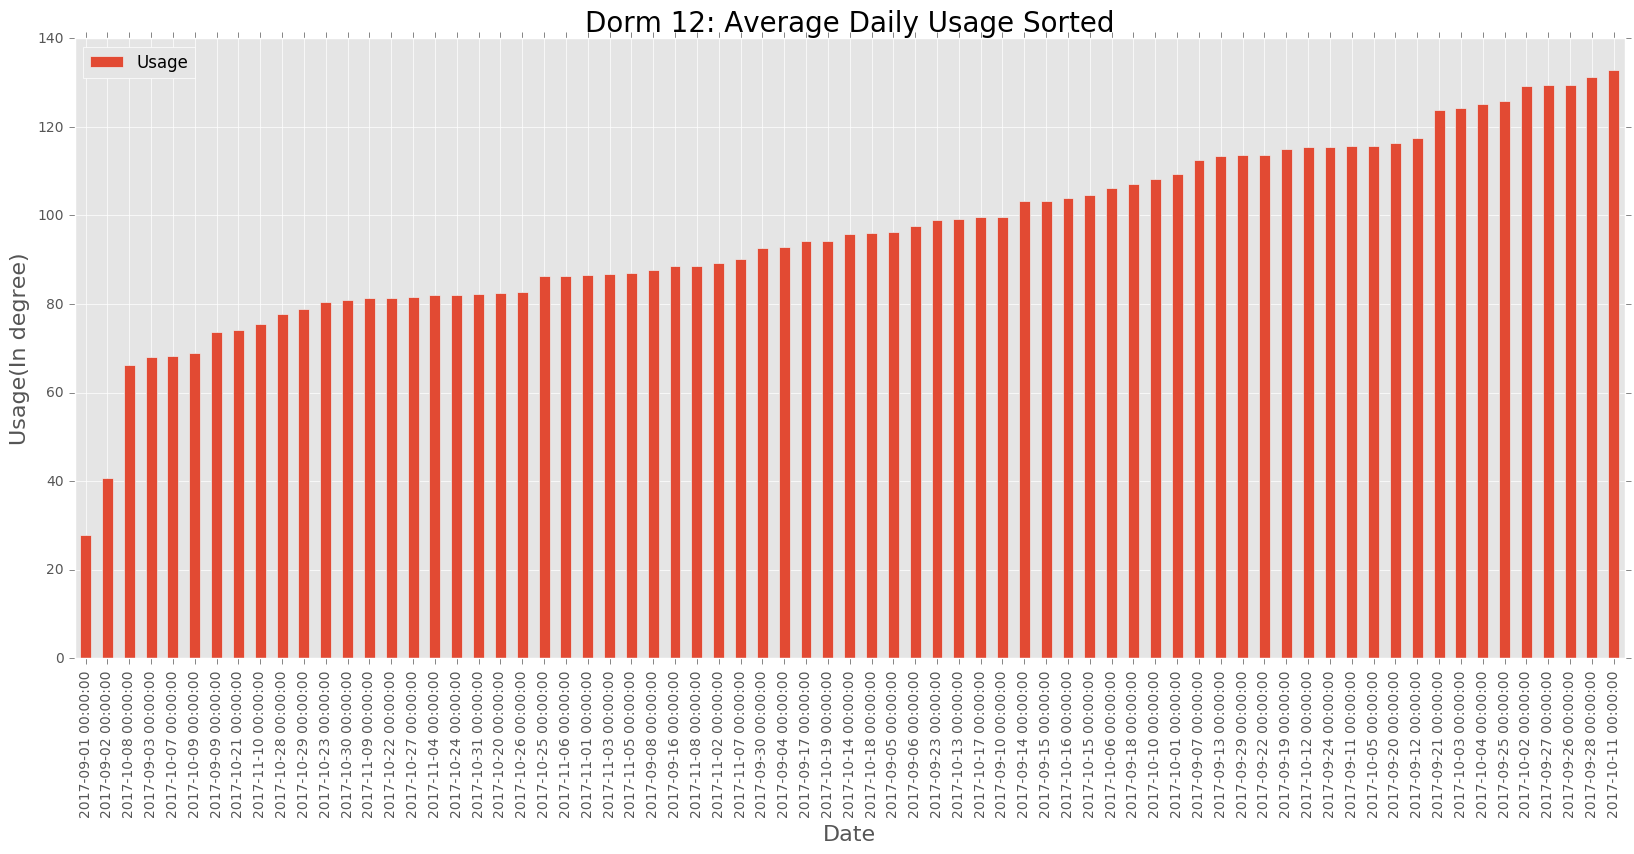

In [58]:
df_dorm_12_dailymean_sorted = df_dorm_12.groupby('Date').mean().sort_values('Usage')
df_dorm_12_dailymean_sorted.Usage.plot.bar(legend = True)
plt.title('Dorm 12: Average Daily Usage Sorted', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Date',fontsize = 16)

In [59]:
# 最高用電的幾天是...
# TBD: 為什麼這幾天會比較高呢？
print('Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10')
print(df_dorm_12_dailysum_sorted[-10:])
print('Top 10 daily AVERAGE use of dorm 12. From 9.01 - 11.10')
print(df_dorm_12_dailymean_sorted[-10:])

Top 10 daily TOTAL use of dorm 12. From 9.01 - 11.10
             Usage  Weekday  Week    Cost
Date                                     
2017-09-12  2821.5      2.0   888  8464.5
2017-09-21  2973.5      4.0   912  8920.5
2017-10-03  2981.0      2.0   960  8943.0
2017-10-04  3003.0      3.0   960  9009.0
2017-09-25  3019.0      1.0   936  9057.0
2017-10-02  3100.0      1.0   960  9300.0
2017-09-27  3105.0      3.0   936  9315.0
2017-09-26  3108.0      2.0   936  9324.0
2017-09-28  3150.0      4.0   936  9450.0
2017-10-11  3189.5      3.0   984  9568.5
Top 10 daily AVERAGE use of dorm 12. From 9.01 - 11.10
                 Usage  Weekday  Week      Cost
Date                                           
2017-09-12  117.562500        2    37  352.6875
2017-09-21  123.895833        4    38  371.6875
2017-10-03  124.208333        2    40  372.6250
2017-10-04  125.125000        3    40  375.3750
2017-09-25  125.791667        1    39  377.3750
2017-10-02  129.166667        1    40  387.5000
2017

觀察：其實最高用電的前十個日子，用平均或總合來看是一樣的。

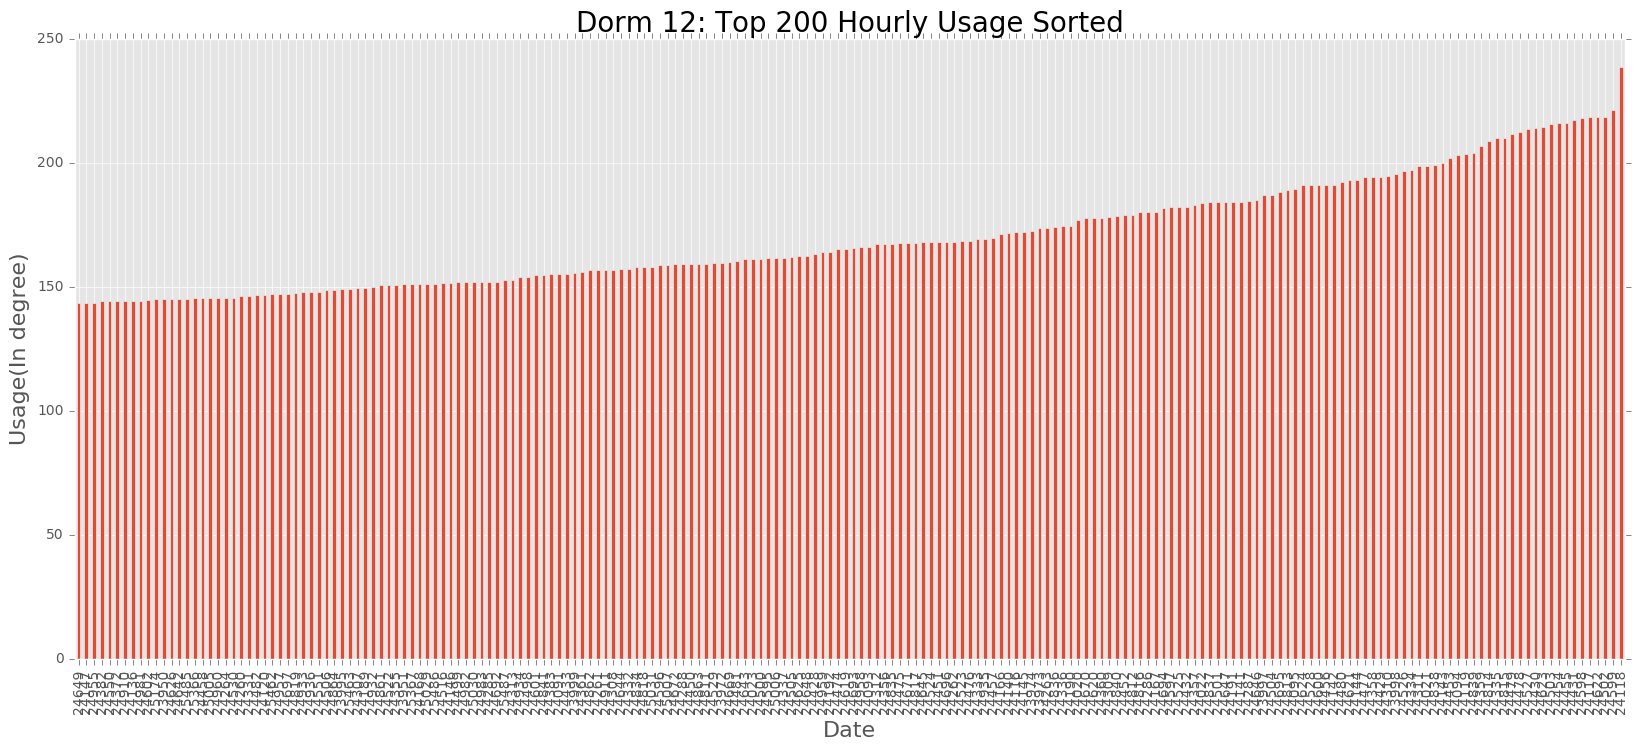

In [60]:
df_dorm_12_sorted_top200 = df_dorm_12.sort_values('Usage')[-200:]
df_dorm_12_sorted_top200.Usage.plot.bar()
plt.title('Dorm 12: Top 200 Hourly Usage Sorted', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Date',fontsize = 16)

In [61]:
# 哪小時最耗電？
df_dorm_12_sorted_top200.Time.value_counts()

22:00    39
23:00    37
21:00    31
00:00    24
20:00    20
01:00    15
19:00    15
02:00     8
18:00     6
03:00     2
12:00     2
16:00     1
Name: Time, dtype: int64

In [62]:
# 星期幾最耗電？
df_dorm_12_sorted_top200.Weekday.value_counts()

3    45
2    45
4    40
1    33
7    21
5    14
6     2
Name: Weekday, dtype: int64

,DateTime,Area,Building,Loop,Type,Usage,Date,Weekday,Time,Week,Cost
24118,2017/09/11 22:00,southArea,dorm_12,mainLoop,dorm,238.5,2017-09-11,1,22:00,37,715.5


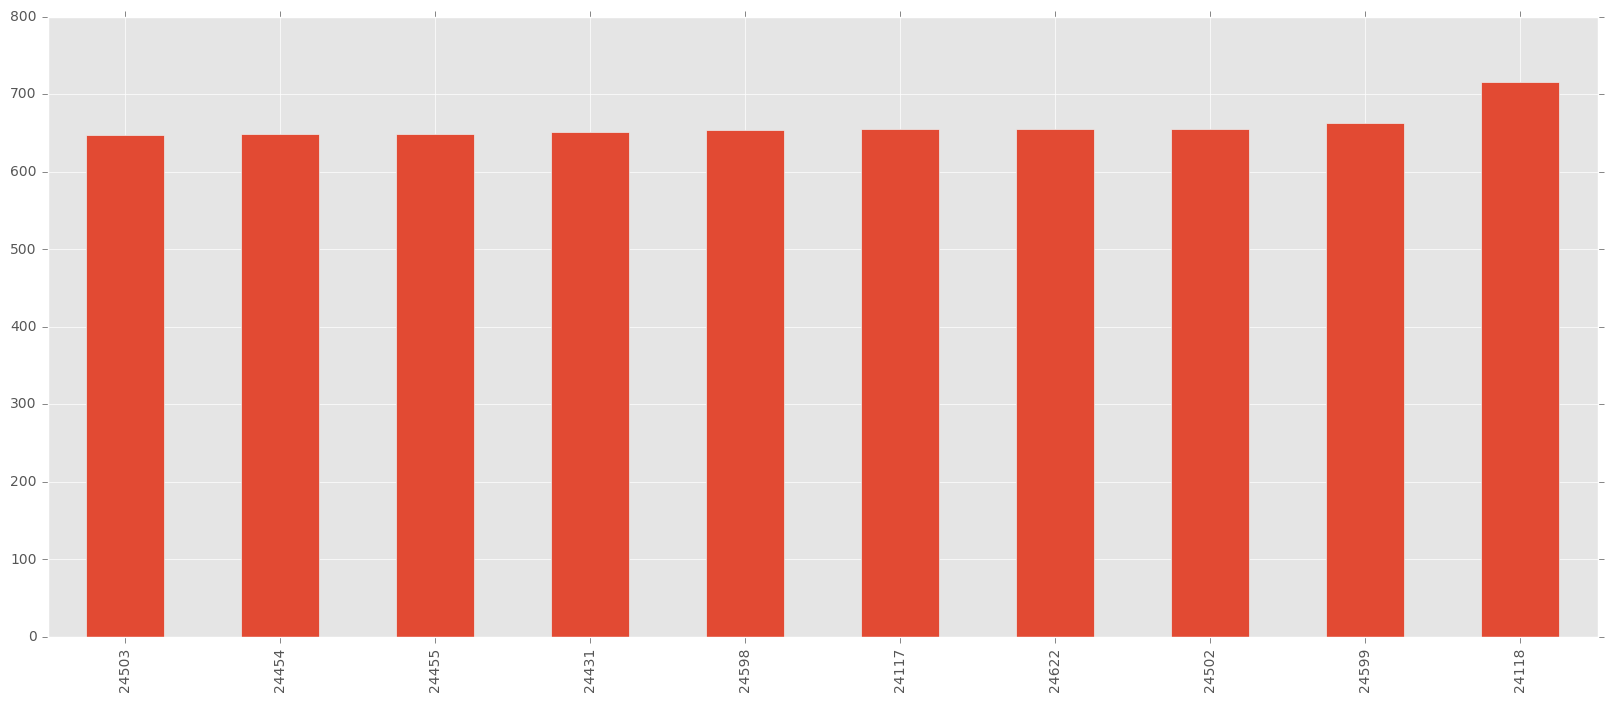

In [63]:


df_dorm_12_sorted_top200[-10:].Cost.plot.bar()
#發現有一天真的特耗電

df_dorm_12_sorted_top200[-1:]
# 2017/09/11 22:00 用電是 238.5, (12舍平均用電是96)

2017/9/11 為什麼用那麼多電呢？
我去查了日曆，原來是開學日啊！

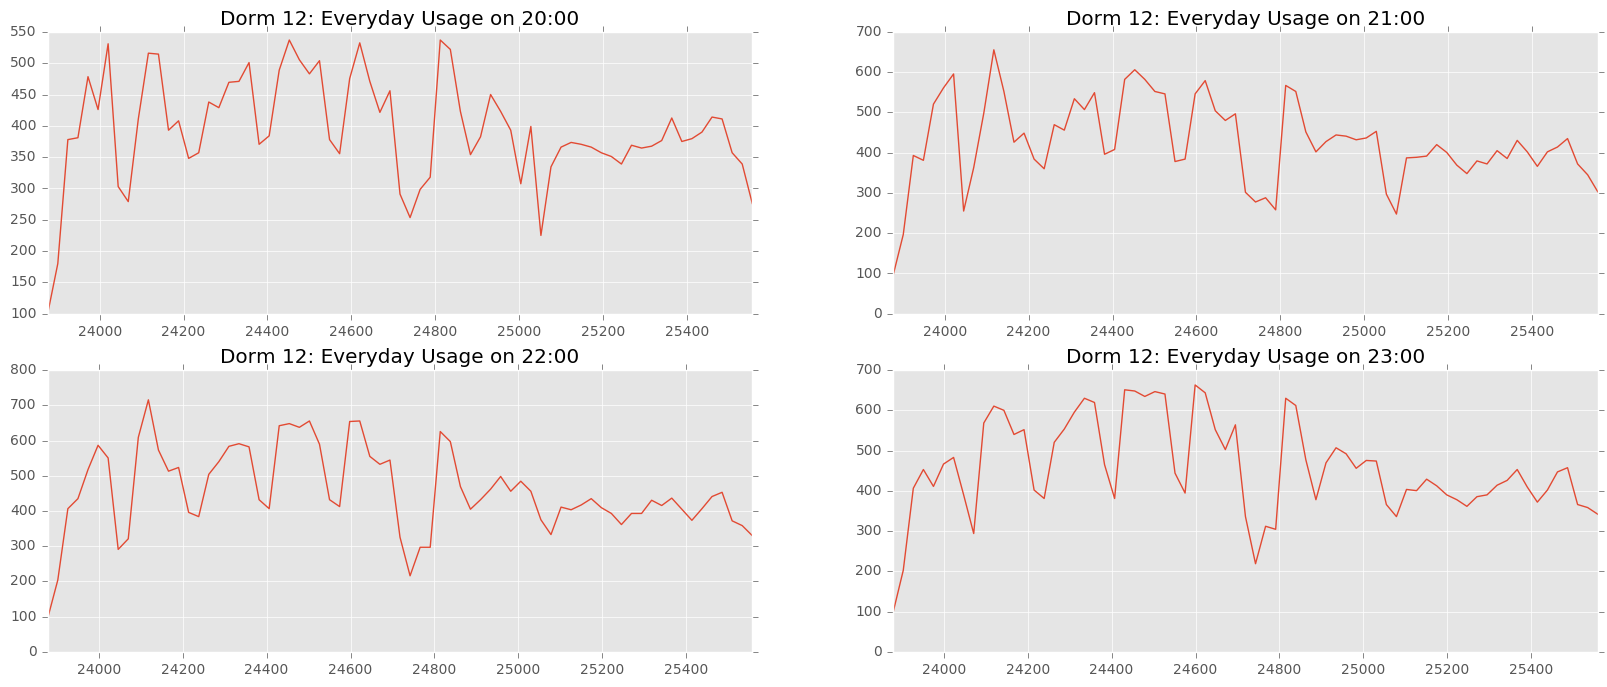

In [64]:
# 觀看某一個小時的用電量，在每天的變化

# df_dorm_12[df_dorm_12.Time == '23:00'].info()
fig, axes = plt.subplots(nrows=2, ncols=2)
df_dorm_12[df_dorm_12.Time == '20:00'].Cost.plot(ax=axes[0,0],title = 'Dorm 12: Everyday Usage on 20:00')
df_dorm_12[df_dorm_12.Time == '21:00'].Cost.plot(ax=axes[0,1],title = 'Dorm 12: Everyday Usage on 21:00')
df_dorm_12[df_dorm_12.Time == '22:00'].Cost.plot(ax=axes[1,0],title = 'Dorm 12: Everyday Usage on 22:00')
df_dorm_12[df_dorm_12.Time == '23:00'].Cost.plot(ax=axes[1,1],title = 'Dorm 12: Everyday Usage on 23:00')


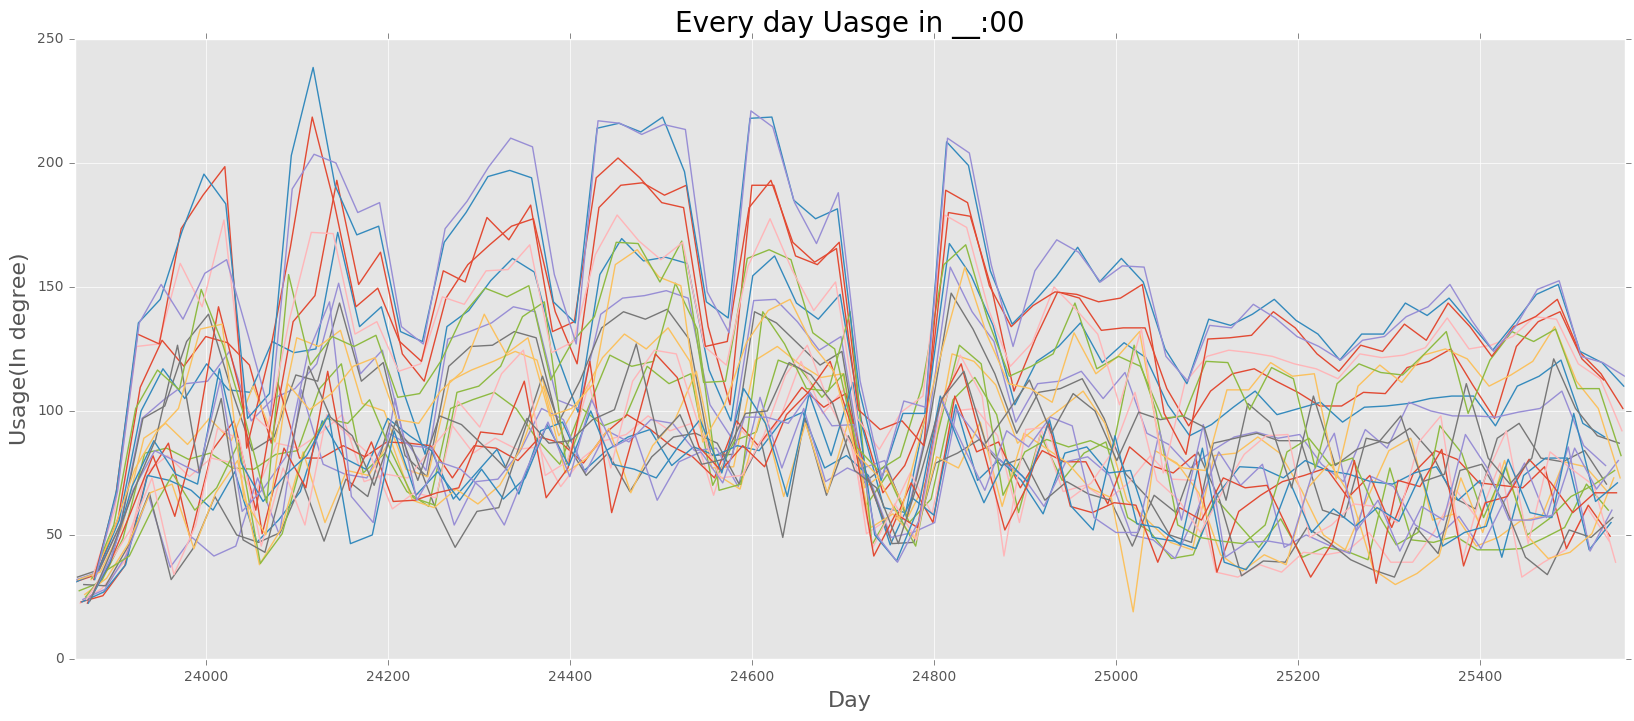

In [65]:
# 未完成
# 觀看24小時分別的用電量，在每天的變化


df_dorm_12.Time.unique()
morning = ['01:00', '02:00', '03:00', '04:00', '05:00', '06:00','07:00', '08:00']
afternoon = ['09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00']
night = [ '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00','00:00']
# df_dorm_12.Time.item in ['18:00','19:00']
# df_dorm_12_byTime_m = df_dorm_12[df_dorm_12.Time.valus in morning].groupby('Time')
# df_dorm_12_byTime_a = df_dorm_12[df_dorm_12.Time in afternoon].groupby('Time')
# df_dorm_12_byTime_n = df_dorm_12[df_dorm_12.Time in night].groupby('Time')

df_dorm_12_byTime = df_dorm_12.groupby('Time')
df_dorm_12_byTime.Usage.plot()
plt.title('Every day Uasge in __:00', fontsize = 20)
pylab.ylabel('Usage(In degree)',fontsize = 16)
pylab.xlabel('Day',fontsize = 16)


# bins = [0, 5, 15, 30]
# names = ['Cheap', 'Normal', 'Expensive']
# df_dorm_12_byTime_m = pd.cut(df_dorm_12.Time,bins, labels=morning)

Week
35    Axes(0.125,0.125;0.775x0.775)
36    Axes(0.125,0.125;0.775x0.775)
37    Axes(0.125,0.125;0.775x0.775)
38    Axes(0.125,0.125;0.775x0.775)
39    Axes(0.125,0.125;0.775x0.775)
40    Axes(0.125,0.125;0.775x0.775)
41    Axes(0.125,0.125;0.775x0.775)
42    Axes(0.125,0.125;0.775x0.775)
43    Axes(0.125,0.125;0.775x0.775)
44    Axes(0.125,0.125;0.775x0.775)
45    Axes(0.125,0.125;0.775x0.775)
Name: Usage, dtype: object

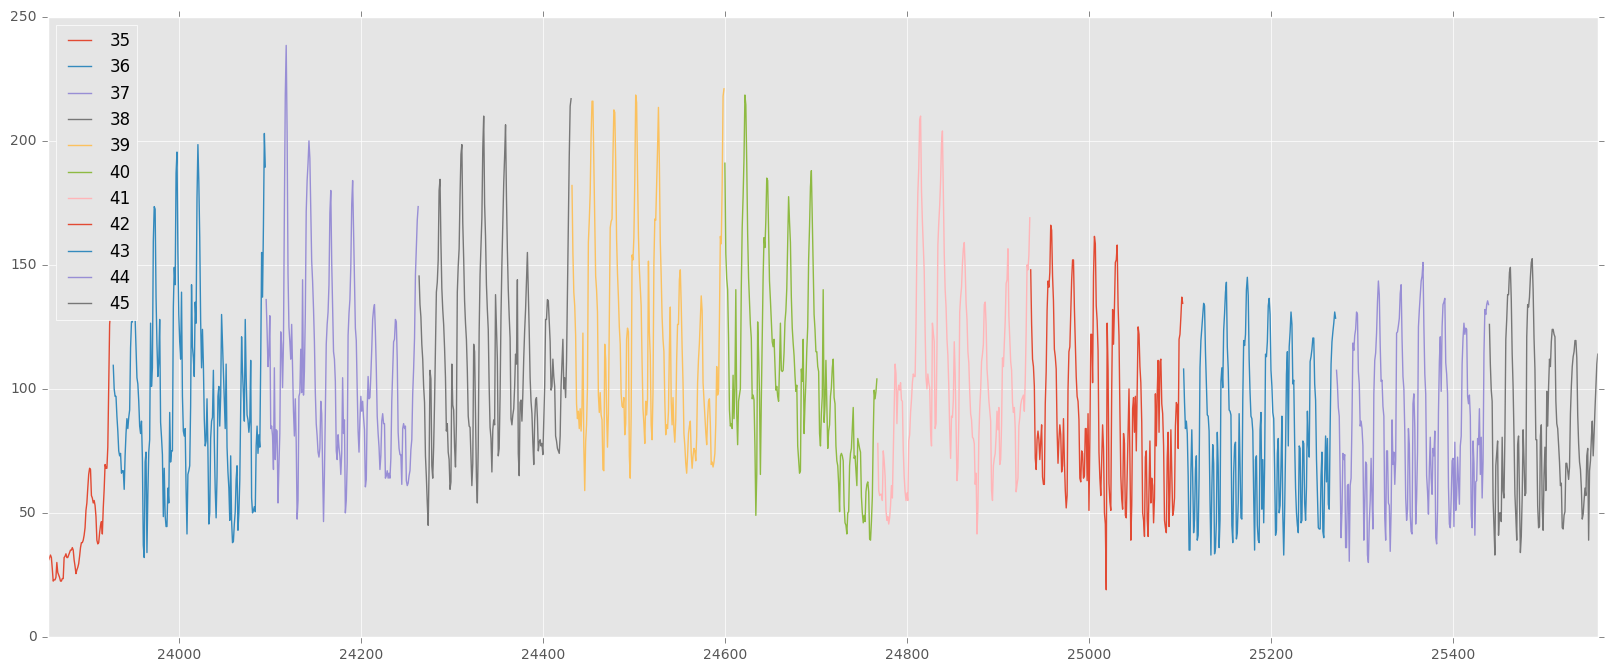

In [66]:
df_dorm_12.groupby(['Week']).Usage.plot(legend = True)
#.Usage.plot(legend = True)

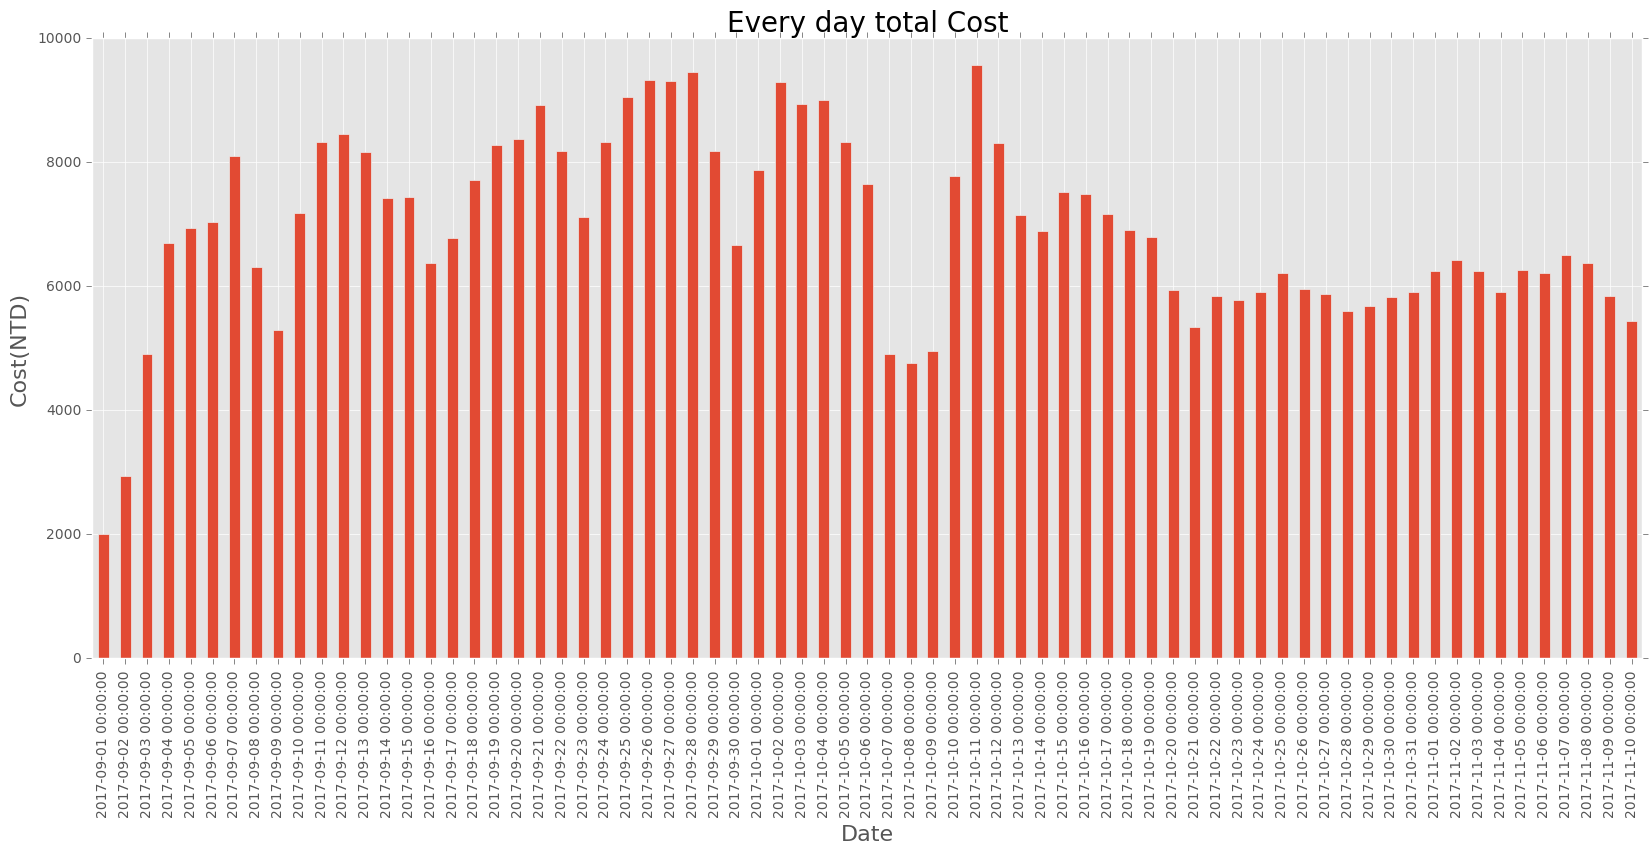

In [70]:
# df_dorm_12.groupby('Date').sum().Usage.plot.bar()
df_dorm_12.groupby('Date').sum().Cost.plot.bar()
plt.title('Every day total Cost', fontsize = 20)
pylab.ylabel('Cost(NTD)',fontsize = 16)
pylab.xlabel('Date',fontsize = 16)

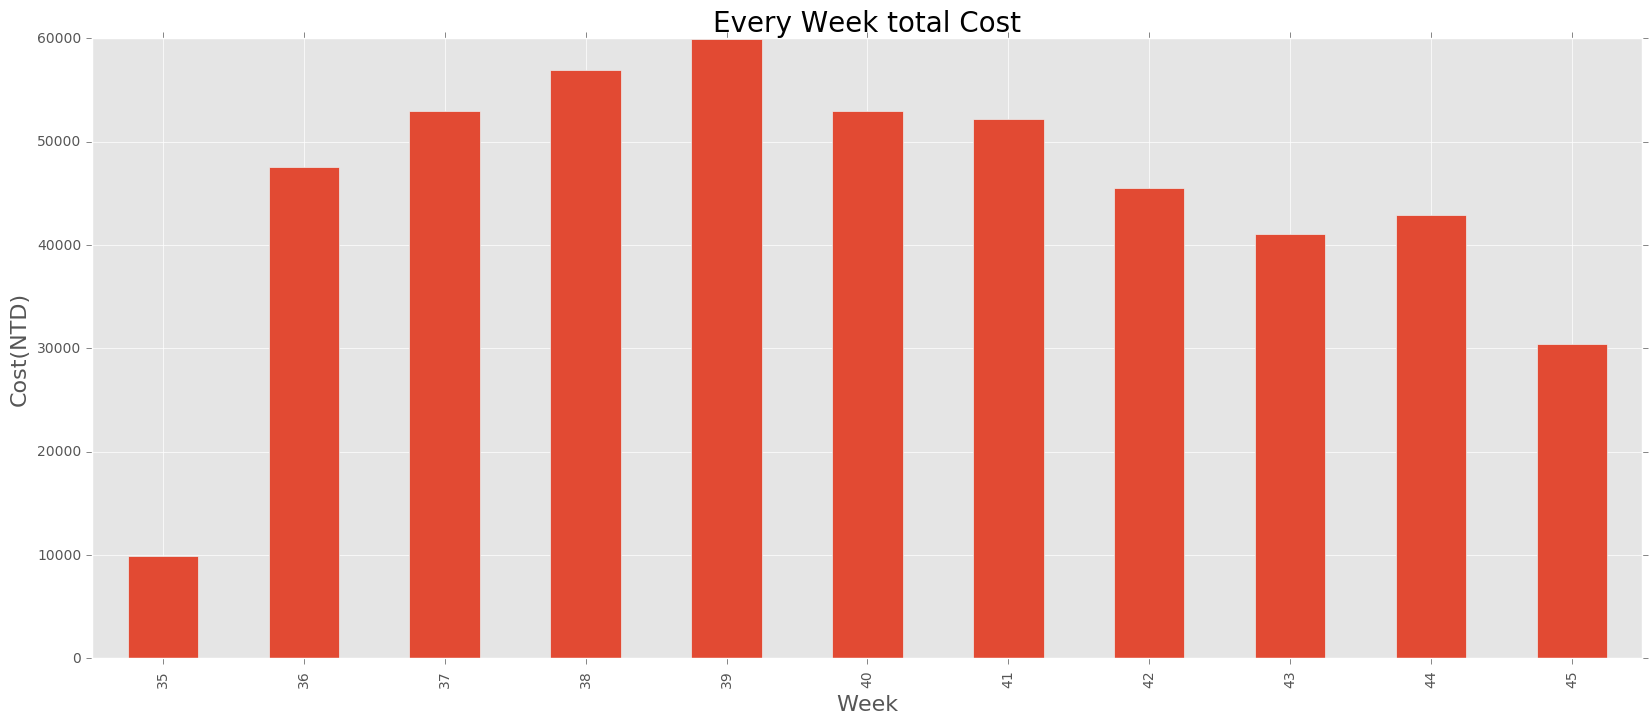

In [73]:
# df_dorm_12.groupby('Date').sum().Usage.plot.bar()
df_dorm_12.groupby('Week').sum().Cost.plot.bar()
plt.title('Every Week total Cost', fontsize = 20)
pylab.ylabel('Cost(NTD)',fontsize = 16)
pylab.xlabel('Week',fontsize = 16)